## Algorithm evaluation
### This df is without dataprep, in order to get reproducable results

In [1]:
use_old_data = False
from exjobb_data import *
from importlib import reload

Using TensorFlow backend.


exjobb data prepare loading...   
data loaded ....


In [75]:
train,test,dev,train_ct,train_eng,train_sv,train_gb,train_col,train_uph=set_data(use_new=True)

using new data...


### Define the training and test data

In [76]:
#train_2['OPT_CODES_translated'].progress_apply(len).describe()

In [77]:
with open('CarBinarizer', 'rb') as f:
    cb = pickle.load(f)
with open('VolvoStats', 'rb') as f:
    stats = pickle.load(f)

In [78]:
def remap(series):
    return np.array(list(map(lambda x: x[0],series.values)))
def create_train_test_split(use_data,test_size=0.2):
    X_train,X_val, y_typecode_train,y_typecode_val,y_sv_train,y_sv_val,y_eng_train,y_eng_val,y_gb_train,y_gb_val,\
        y_uph_train,y_uph_val,y_col_train,y_col_val,y_opt_train,y_opt_val= train_test_split(use_data,\
        remap(use_data['TYPECODE_onehot']),\
        remap(use_data['SALESVERSIONCODE_onehot']),\
        remap(use_data['ENGINECODE_onehot']),\
        remap(use_data['GEARBOXCODE_onehot']),\
        remap(use_data['UPHOLSTERY_onehot']),\
        remap(use_data['COLOUR_onehot']),
        remap(use_data['OPT_CODES_onehot']),test_size=test_size)
    return X_train,X_val, y_typecode_train,y_typecode_val,y_sv_train,y_sv_val,y_eng_train,y_eng_val,y_gb_train,y_gb_val,y_uph_train,y_uph_val,y_col_train,y_col_val,y_opt_train,y_opt_val

#X_train,X_val, y_typecode_train,y_typecode_val,y_sv_train,y_sv_val,y_eng_train,y_eng_val,y_gb_train,y_gb_val,y_uph_train,y_uph_val,y_col_train,y_col_val,y_opt_train,y_opt_val= create_train_test_split(train,test_size=0.2)

In [79]:

X_train_ct, y_train_ct = train_ct, remap(train_ct['TYPECODE_onehot'])
X_train_sv, y_train_sv = train_sv,remap(train_sv['SALESVERSIONCODE_onehot'])
X_train_eng, y_train_eng = train_eng,remap(train_eng['ENGINECODE_onehot'])
X_train_gb, y_train_gb = train_gb,remap(train_gb['GEARBOXCODE_onehot'])
X_train_col, y_train_col = train_col,remap(train_col['COLOUR_onehot'])
X_train_uph, y_train_uph = train_uph,remap(train_uph['UPHOLSTERY_onehot'])
X_train_opt, y_train_opt = train_ct,remap(train_ct['OPT_CODES_onehot'])


In [80]:
y_train_ct.shape

(109274, 11)

### Generic Keras callbacks

In [81]:
def callbacks(name):
    dt_format = "%Y%m%d-%H%M%S"
    model_name = f"{name}_{datetime.now().strftime(dt_format)}"
    return [
        TensorBoard(log_dir='./logs/{}'.format(model_name)),
        ModelCheckpoint('./models/{}.mdl_wts.hdf5'.format(model_name),
                        save_best_only=True, monitor='val_loss', mode='min'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                          patience=5, verbose=1, mode='min'),
        EarlyStopping(restore_best_weights=True, patience=10)
    ]

# AutoEncoder

Theory; We let the data speak for it self, so we do 'automatic' feature extraction, by running an $\textit{AutoEncoder}$ over the different datasets. The specified latent dimensions will then represent the data in a lower dimension(s).

The AutoEncoders are models as follows:
NNEncoder(data) => latent_dimensions => NNDecoder(data)

In [82]:
class AutoEncoder:
    def __init__(self, input_size, latent_dim, loss='mse',decoder_name='',output_activation=None):
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.loss=loss
        if output_activation is None:
            self.output_activation = 'softmax' if 'entropy' in self.loss else 'relu'
        else:
            self.output_activation = output_activation
            
        self.decoder_name=decoder_name
        self.decoder_output_layer = lambda units,activation: Dense(units,activation=activation,name='default_out')
        self._build()
    
    def _build(self):       
        inputs = Input(shape=(self.input_size,))
        first = Dense(1000,activation='relu')(inputs)
        first = Dense(1000, activation='relu')(first)
        
        latent = Dense(self.latent_dim, name='latent')(first)
        
        self.encoder = Model(inputs, latent, name='encoder')
        self.encoder.summary()
        latent_inputs = Input(shape=(self.latent_dim,),name='decoder_input')        
        last = Dense(1000,activation='relu')(latent_inputs)
        last = Dense(1000, activation='relu')(last)
        
        #out = Dense(self.input_size, activation=self.output_activation)(last)
        out = self.decoder_output_layer(units=self.input_size, activation=self.output_activation)(last)
            
        self.decoder = Model(latent_inputs, out, name=f'decoder_{self.decoder_name}')
        self.decoder.summary()
        autoencoder = Model(inputs, self.decoder(self.encoder(inputs)), name='autoencoder')
        autoencoder.summary()
        
        if 'entropy' in self.loss:
            autoencoder.compile(loss=self.loss, optimizer=optimizers.Adam(lr=0.001),metrics=['accuracy'])
        else:
            autoencoder.compile(loss=self.loss, optimizer=optimizers.Adam(lr=0.001))
            
        self.model = autoencoder
        

    def get_encoder(self):
        for layer in self.encoder.layers:
            layer.trainable=False
        return self.encoder
    
    def get_decoder(self):
        for layer in self.decoder.layers:
            layer.trainable=False
        return self.decoder
    
    def callbacks(self, X_test):
        return [
            TensorBoard(batch_size=64,
                          embeddings_freq=1,
                          embeddings_layer_names=['latent'],
                          embeddings_metadata='metadata.tsv',
                          embeddings_data=X_test)
        ]

### Here, we do a special case, for the options AutoEncoder.
Basically, since options are note one-hot encoded, rather the options are represented as multi-hot vecotrs, we do a slight modification of the AutoEncoder above, by adding a "priori layer".

The priori layer normalizes the the outputs from the multi-sigmodal output layer, by a prior known distribution.
Simply put; We know on beforehand (from statistics) the frequency of every option (how often its included). When we do predictions from the autoencoder, we apply the following: 

$\pi$ = statistics for every option
$v$ = the predicted vector, with probabilites

$$
    output = \pi \otimes v
$$

In [83]:
from keras.layers import Layer
from keras import backend as K
class PrioriDenseLayer(Dense):
        def __init__(self, priori_dist, **kwargs):
            print('PRIORI DENSE')
            self.priori_dist = priori_dist
            print(f'units:{kwargs}, {self.priori_dist.shape[0]}')
            assert self.priori_dist.shape[0] == kwargs['units']
            self.priori_dist = K.variable(self.priori_dist.T)
            super().__init__(**kwargs)
        
        def call(self, x):
            super_result = super().call(x)
            print('super_result', super_result)
            print('priori',self.priori_dist)
            calc= super_result*self.priori_dist
            print('calc',calc)
            return calc
            
            
class MultiClassAutoEncoder(AutoEncoder):
    def __init__(self,input_size, latent_dim, priori_dist, decoder_name='',output_activation=None):
        self.decoder_output_layer = lambda units,activation: PrioriDenseLayer(priori_dist, units=units,activation='sigmoid',name='priori_dense')
        print('MCAE')
        self.priori_dist = priori_dist
        super().__init__(input_size, latent_dim, 'binary_crossentropy',decoder_name,'sigmoid')
    def _build(self):
        #self.decoder_output_layer = lambda units,activation: PrioriDenseLayer(self.priori_dist, units=units,activation='sigmoid',name='priori_dense')
        super()._build()



In [84]:
index_dist = []
for opt in cb.types_binarizer['OPT'].classes_.tolist():
    if not opt in stats.stats[2019]['OPT']:
        pass
#        avaregae computed to: 0.03030649501116675
        index_dist += [0.030649501116675]
        #print(opt, 0.030649501116675,cb.types_binarizer['OPT'].classes_.tolist().index(opt))
    else:
        #print(opt, stats.stats[2019]['OPT'][opt],cb.types_binarizer['OPT'].classes_.tolist().index(opt))
        index_dist+=[stats.stats[2019]['OPT'][opt]]
index_dist = np.array(index_dist).reshape(-1,1)


In [85]:
#the context autoencoder
context_autoencoder = AutoEncoder(X_train_ct[user_columns].shape[1], 10)
#car components auto encoders:
ct_autoencoder = AutoEncoder(y_train_ct.shape[1], 5,loss='categorical_crossentropy',decoder_name='cartype')
sv_autoencoder = AutoEncoder(y_train_sv.shape[1], 5, loss='categorical_crossentropy',decoder_name='sv')
eng_autoencoder = AutoEncoder(y_train_eng.shape[1], 5,loss='categorical_crossentropy',decoder_name='eng')
gb_autoencoder = AutoEncoder(y_train_gb.shape[1], 5,loss='categorical_crossentropy', decoder_name='gb')
col_autoencoder = AutoEncoder(y_train_col.shape[1], 5,loss='categorical_crossentropy', decoder_name='color')
uph_autoencoder = AutoEncoder(y_train_uph.shape[1], 5,loss='categorical_crossentropy', decoder_name='uph')
opt_autoencoder = MultiClassAutoEncoder(y_train_opt.shape[1], 5,index_dist, decoder_name='opt')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 54)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 1000)              55000     
_________________________________________________________________
dense_66 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
latent (Dense)               (None, 10)                10010     
Total params: 1,066,010
Trainable params: 1,066,010
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 10)                0         
_________________________________________________________________


### How the autoencoder is structured

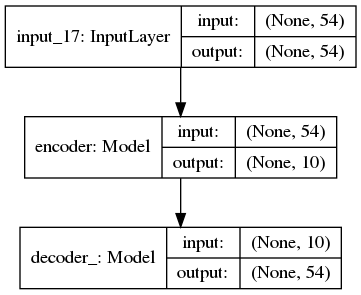

In [86]:
plot_model(context_autoencoder.model, show_shapes=True, show_layer_names=True, to_file='context_autoencoder.png')
display(Image(filename='context_autoencoder.png'))

In [87]:
context_autoencoder.model.fit(X_train_ct[user_columns],X_train_ct[user_columns], validation_data=(dev[user_columns],dev[user_columns]), epochs=5,batch_size=512,verbose=2)

Train on 109274 samples, validate on 7266 samples
Epoch 1/5
 - 13s - loss: 0.0059 - val_loss: 0.0029
Epoch 2/5
 - 9s - loss: 0.0019 - val_loss: 0.0014
Epoch 3/5
 - 9s - loss: 0.0013 - val_loss: 0.0013
Epoch 4/5
 - 9s - loss: 0.0013 - val_loss: 0.0013
Epoch 5/5
 - 9s - loss: 0.0012 - val_loss: 0.0010


In [88]:
opt_autoencoder.model.fit(y_train_opt,y_train_opt,validation_data=(remap(dev['OPT_CODES_onehot']),remap(dev['OPT_CODES_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 109274 samples, validate on 7266 samples
Epoch 1/5
 - 17s - loss: 0.0592 - acc: 0.9848 - val_loss: 0.0391 - val_acc: 0.9876
Epoch 2/5
 - 13s - loss: 0.0285 - acc: 0.9903 - val_loss: 0.0331 - val_acc: 0.9891
Epoch 3/5
 - 13s - loss: 0.0241 - acc: 0.9916 - val_loss: 0.0307 - val_acc: 0.9898
Epoch 4/5
 - 13s - loss: 0.0217 - acc: 0.9924 - val_loss: 0.0294 - val_acc: 0.9903
Epoch 5/5
 - 13s - loss: 0.0200 - acc: 0.9929 - val_loss: 0.0287 - val_acc: 0.9906


In [89]:
ct_autoencoder.model.fit(y_train_ct,y_train_ct,validation_data=(remap(dev['TYPECODE_onehot']),remap(dev['TYPECODE_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 109274 samples, validate on 7266 samples
Epoch 1/5
 - 14s - loss: 0.0504 - acc: 0.9894 - val_loss: 1.4756e-07 - val_acc: 1.0000
Epoch 2/5
 - 10s - loss: 1.2753e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/5
 - 10s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/5
 - 10s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/5
 - 10s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000


In [90]:
sv_autoencoder.model.fit(y_train_sv,y_train_sv,validation_data=(remap(dev['SALESVERSIONCODE_onehot']),remap(dev['SALESVERSIONCODE_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 136587 samples, validate on 7266 samples
Epoch 1/5
 - 16s - loss: 0.0412 - acc: 0.9932 - val_loss: 1.1933e-07 - val_acc: 1.0000
Epoch 2/5
 - 12s - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/5
 - 12s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/5
 - 12s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/5
 - 12s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000


In [91]:
eng_autoencoder.model.fit(y_train_eng,y_train_eng,validation_data=(remap(dev['ENGINECODE_onehot']),remap(dev['ENGINECODE_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 143520 samples, validate on 7266 samples
Epoch 1/5
 - 17s - loss: 0.0492 - acc: 0.9908 - val_loss: 2.9079e-07 - val_acc: 1.0000
Epoch 2/5
 - 13s - loss: 2.1269e-07 - acc: 1.0000 - val_loss: 1.3690e-07 - val_acc: 1.0000
Epoch 3/5
 - 13s - loss: 1.5750e-07 - acc: 1.0000 - val_loss: 1.2932e-07 - val_acc: 1.0000
Epoch 4/5
 - 13s - loss: 1.3841e-07 - acc: 1.0000 - val_loss: 1.2300e-07 - val_acc: 1.0000
Epoch 5/5
 - 13s - loss: 1.2506e-07 - acc: 1.0000 - val_loss: 1.2047e-07 - val_acc: 1.0000


In [92]:
gb_autoencoder.model.fit(y_train_gb,y_train_gb,validation_data=(remap(dev['GEARBOXCODE_onehot']),remap(dev['GEARBOXCODE_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 92982 samples, validate on 7266 samples
Epoch 1/5
 - 13s - loss: 0.0357 - acc: 0.9917 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/5
 - 8s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/5
 - 8s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/5
 - 8s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/5
 - 8s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000


In [93]:
col_autoencoder.model.fit(y_train_col,y_train_col,validation_data=(remap(dev['COLOUR_onehot']),remap(dev['COLOUR_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 156488 samples, validate on 7266 samples
Epoch 1/5
 - 18s - loss: 0.0661 - acc: 0.9811 - val_loss: 2.2141e-06 - val_acc: 1.0000
Epoch 2/5
 - 14s - loss: 9.4613e-07 - acc: 1.0000 - val_loss: 6.5413e-07 - val_acc: 1.0000
Epoch 3/5
 - 14s - loss: 3.6901e-07 - acc: 1.0000 - val_loss: 3.0710e-07 - val_acc: 1.0000
Epoch 4/5
 - 14s - loss: 2.2527e-07 - acc: 1.0000 - val_loss: 2.0030e-07 - val_acc: 1.0000
Epoch 5/5
 - 14s - loss: 1.6965e-07 - acc: 1.0000 - val_loss: 1.5864e-07 - val_acc: 1.0000


In [94]:
uph_autoencoder.model.fit(y_train_uph,y_train_uph,validation_data=(remap(dev['UPHOLSTERY_onehot']),remap(dev['UPHOLSTERY_onehot'])), epochs=5, batch_size=256,verbose=2)

Train on 73563 samples, validate on 7266 samples
Epoch 1/5
 - 12s - loss: 0.2994 - acc: 0.9303 - val_loss: 4.4037e-05 - val_acc: 1.0000
Epoch 2/5
 - 7s - loss: 2.4134e-05 - acc: 1.0000 - val_loss: 1.2295e-05 - val_acc: 1.0000
Epoch 3/5
 - 7s - loss: 9.7168e-06 - acc: 1.0000 - val_loss: 6.2016e-06 - val_acc: 1.0000
Epoch 4/5
 - 7s - loss: 5.4212e-06 - acc: 1.0000 - val_loss: 3.7802e-06 - val_acc: 1.0000
Epoch 5/5
 - 7s - loss: 3.4348e-06 - acc: 1.0000 - val_loss: 2.4845e-06 - val_acc: 1.0000


## The AutoInOutModel
This is a special construction, Here we make use of the context encoder, and the car components auto decoders.
In between these, we create a model that will try to learn the mapping between the context, and the respective component(s). The encoder/decoders are also not trainable in this step, (they were fitted earlier)

In [95]:
class AutoInOutModel:
    def __init__(self, in_autoencoder, out_autoencoders):
        self.in_autoencoder = in_autoencoder
        self.out_autoencoders = out_autoencoders
        self._build()
        
    def _build(self):

        x1_encoder = self.in_autoencoder.get_encoder()
        
        x1_inputs = x1_encoder.inputs[0]
        
        m_inputs = Input(shape=(x1_encoder.outputs[0].shape[1].value,),name='in_middle')
        
        outputs = []
        for i in range(len(self.out_autoencoders)):
            middle=Dense(100,name='middle')(m_inputs)
            throttle = Dense(1000,name=f'{i}_throttle_middle_1')(LeakyReLU()(middle))
            throttle = Dense(1000,name=f'{i}_throttle_middle_2')(LeakyReLU()(throttle))
            throttle = Dense(100,name=f'{i}_throttle_middle_3')(LeakyReLU()(throttle))
            throttle = Dense(100,name=f'{i}_throttle_middle_4')(LeakyReLU()(throttle))
            #throttle = Dense(1000,name=f'{i}_throttle_middle_5')(LeakyReLU()(throttle))
            #throttle = Dense(1000,name=f'{i}_throttle_middle_6')(LeakyReLU()(throttle))
            
            #throttle = Dense(1000,name=f'{i}_throttle_middle_7')(LeakyReLU()(throttle))
            
            throttle = Dense(100,name=f'{i}_throttle_middle_8')(LeakyReLU()(throttle))
            
            throttle = Dense(5,name=f'{i}_throttle_middle_9')(LeakyReLU()(throttle))
            decoder = self.out_autoencoders[i].get_decoder()
            middlemodel = Model(m_inputs,throttle,name=f'{decoder.name}_model_inbetwee')
            outputs += [decoder(middlemodel(x1_encoder(x1_inputs)))]       
        
        self.model = Model(x1_inputs,outputs,name='complete')
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(0.001),metrics=['accuracy'])
        self.model.summary()
        
ct_automodel = AutoInOutModel(context_autoencoder,[ct_autoencoder])
eng_automodel = AutoInOutModel(context_autoencoder,[eng_autoencoder])
gb_automodel = AutoInOutModel(context_autoencoder,[gb_autoencoder])
sv_automodel = AutoInOutModel(context_autoencoder,[sv_autoencoder])
col_automodel = AutoInOutModel(context_autoencoder,[col_autoencoder])
uph_automodel = AutoInOutModel(context_autoencoder,[uph_autoencoder])
opt_automodel = AutoInOutModel(context_autoencoder,[opt_autoencoder])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 54)                0         
_________________________________________________________________
encoder (Model)              (None, 10)                1066010   
_________________________________________________________________
decoder_cartype_model_inbetw (None, 5)                 1223905   
_________________________________________________________________
decoder_cartype (Model)      (None, 11)                1018011   
Total params: 3,307,926
Trainable params: 1,223,905
Non-trainable params: 2,084,021
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 54)                0         
__________________________________________________________

In [96]:
opt_automodel = AutoInOutModel(context_autoencoder,[opt_autoencoder])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 54)                0         
_________________________________________________________________
encoder (Model)              (None, 10)                1066010   
_________________________________________________________________
decoder_opt_model_inbetwee ( (None, 5)                 1223905   
_________________________________________________________________
decoder_opt (Model)          (None, 278)               1285278   
Total params: 3,575,193
Trainable params: 1,223,905
Non-trainable params: 2,351,288
_________________________________________________________________


In [97]:
history=opt_automodel.model.fit(X_train_opt[user_columns],[y_train_opt],validation_data=(dev[user_columns], remap(dev['OPT_CODES_onehot'])),epochs=25,batch_size=128)

Train on 109274 samples, validate on 7266 samples
Epoch 1/25
109274/109274 [==============================] - 30s 276us/step - loss: 24.2543 - acc: 0.0056 - val_loss: 25.3499 - val_acc: 0.0034
Epoch 2/25
109274/109274 [==============================] - 26s 234us/step - loss: 24.0698 - acc: 0.0042 - val_loss: 25.3534 - val_acc: 0.0034
Epoch 3/25
109274/109274 [==============================] - 26s 237us/step - loss: 24.0429 - acc: 0.0041 - val_loss: 25.2962 - val_acc: 0.0036
Epoch 4/25
109274/109274 [==============================] - 26s 238us/step - loss: 24.0553 - acc: 0.0070 - val_loss: 25.3273 - val_acc: 0.0034
Epoch 5/25
109274/109274 [==============================] - 26s 236us/step - loss: 23.9988 - acc: 0.0044 - val_loss: 25.3573 - val_acc: 0.0036
Epoch 6/25
109274/109274 [==============================] - 26s 237us/step - loss: 23.9867 - acc: 0.0044 - val_loss: 25.3318 - val_acc: 0.0039
Epoch 7/25
109274/109274 [==============================] - 26s 239us/step - loss: 23.9626 -

In [98]:
#X_train_eng, X_val_eng, y_train_eng,y_val_eng
history=ct_automodel.model.fit(X_train_ct[user_columns],[y_train_ct],validation_data=(dev[user_columns], remap(dev['TYPECODE_onehot'])),epochs=500,batch_size=256,callbacks=callbacks("autoinoutmodel_ct"))
history=eng_automodel.model.fit(X_train_eng[user_columns],[y_train_eng],validation_data=(dev[user_columns], remap(dev['ENGINECODE_onehot'])),epochs=500,batch_size=256,callbacks=callbacks("autoinoutmodel_eng"))
history=gb_automodel.model.fit(X_train_gb[user_columns],[y_train_gb],validation_data=(dev[user_columns], remap(dev['GEARBOXCODE_onehot'])),epochs=500,batch_size=256,callbacks=callbacks("autoinoutmodel_gb"))
history=sv_automodel.model.fit(X_train_sv[user_columns],[y_train_sv],validation_data=(dev[user_columns], remap(dev['SALESVERSIONCODE_onehot'])),epochs=500,batch_size=256,callbacks=callbacks("autoinoutmodel_sv"))
history=col_automodel.model.fit(X_train_col[user_columns],[y_train_col],validation_data=(dev[user_columns], remap(dev['COLOUR_onehot'])),epochs=500,batch_size=256,callbacks=callbacks("autoinoutmodel_col"))
history=uph_automodel.model.fit(X_train_uph[user_columns],[y_train_uph],validation_data=(dev[user_columns], remap(dev['UPHOLSTERY_onehot'])),epochs=500,batch_size=256,callbacks=callbacks("autoinoutmodel_uph"))

Train on 109274 samples, validate on 7266 samples
Epoch 1/500
109274/109274 [==============================] - 15s 133us/step - loss: 2.1578 - acc: 0.2134 - val_loss: 2.3745 - val_acc: 0.1068
Epoch 2/500
109274/109274 [==============================] - 13s 123us/step - loss: 2.1310 - acc: 0.2277 - val_loss: 2.3765 - val_acc: 0.1162
Epoch 3/500
109274/109274 [==============================] - 13s 123us/step - loss: 2.1189 - acc: 0.2362 - val_loss: 2.3654 - val_acc: 0.0930
Epoch 4/500
109274/109274 [==============================] - 13s 123us/step - loss: 2.1031 - acc: 0.2466 - val_loss: 2.3757 - val_acc: 0.1035
Epoch 5/500
109274/109274 [==============================] - 13s 122us/step - loss: 2.0853 - acc: 0.2594 - val_loss: 2.3956 - val_acc: 0.0929
Epoch 6/500
109274/109274 [==============================] - 13s 123us/step - loss: 2.0667 - acc: 0.2686 - val_loss: 2.4319 - val_acc: 0.0848
Epoch 7/500
109274/109274 [==============================] - 13s 122us/step - loss: 2.0457 - acc: 

In [99]:
#print(automodel.model.metrics_names)
print('ct',ct_automodel.model.evaluate(test[user_columns],remap(test['TYPECODE_onehot'])))
print('eng',eng_automodel.model.evaluate(test[user_columns],remap(test['ENGINECODE_onehot'])))
print('sv',sv_automodel.model.evaluate(test[user_columns],remap(test['SALESVERSIONCODE_onehot'])))
print('gb',gb_automodel.model.evaluate(test[user_columns],remap(test['GEARBOXCODE_onehot'])))
print('col',col_automodel.model.evaluate(test[user_columns],remap(test['COLOUR_onehot'])))
print('uph',uph_automodel.model.evaluate(test[user_columns],remap(test['UPHOLSTERY_onehot'])))
print('opt',opt_automodel.model.evaluate(test[user_columns],remap(test['OPT_CODES_onehot'])))

9082/9082 [==============================] - 2s 241us/step
ct [2.3558564200797183, 0.09612420172178517]
9082/9082 [==============================] - 2s 242us/step
eng [2.9764678274002194, 0.061330103503072136]
9082/9082 [==============================] - 2s 242us/step
sv [2.496767970544865, 0.0752036996338368]
9082/9082 [==============================] - 2s 242us/step
gb [1.6371024097805111, 0.19246861926655076]
9082/9082 [==============================] - 2s 242us/step
col [3.1221218208887587, 0.06925787271936279]
9082/9082 [==============================] - 2s 250us/step
uph [4.0878321490763465, 0.014203919845546455]
9082/9082 [==============================] - 2s 258us/step
opt [26.354553316322566, 0.003193129266681348]


In [100]:
class AggModel:
    def __init__(self,ctmodel,engmodel,svmodel,gbmodel,colmodel,uphmodel,optmodel):
        self.ctmodel = ctmodel
        self.engmodel = engmodel
        self.svmodel = svmodel
        self.gbmodel = gbmodel
        self.colmodel = colmodel
        self.uphmodel = uphmodel
        self.optmodel = optmodel
        
    
    def predict(self, X):
        ct = self.ctmodel.predict(X)
        eng = self.engmodel.predict(X)        
        sv = self.svmodel.predict(X)        
        gb = self.gbmodel.predict(X)        
        col = self.colmodel.predict(X)
        uph = self.uphmodel.predict(X)
        opt = self.optmodel.predict(X)
        
        return ct,eng,sv,gb,col,uph,opt
aggmodel = AggModel(ct_automodel.model,eng_automodel.model,sv_automodel.model,gb_automodel.model,col_automodel.model,uph_automodel.model,opt_automodel.model)

In [104]:
evaluator = exjobb_data.Evaluator(test,2,sample_size=100)
evaluator.enqueue(exjobb_data.Pno34ModelResolver(aggmodel,cb,pno12_solver,pnotype=PNO12), 'model_nosolver_pno12')
evaluator.enqueue(exjobb_data.Pno34ModelResolver(aggmodel,cb,pno12_solver,pnotype=PNO34), 'model_nosolver_pno34')
evaluator.enqueue(exjobb_data.Pno34ModelResolver(aggmodel,cb,pno12_solver,pnotype=CIS,use_solver=False), 'model_nosolver_CIS')
evaluator.enqueue(exjobb_data.Pno34ModelResolver(aggmodel,cb,pno12_solver,pnotype=CIS,use_solver=True), 'model_w.solver_CIS')

for t in np.arange(0.1,1.1,0.2):
    evaluator.enqueue(exjobb_data.Pno34ModelResolver(aggmodel,cb,pno12_solver,threshold=t,pnotype=CIS,use_solver=False), f'model_nosolver.solver_thres:{t}_CIS')

for t in np.arange(0.1,1.1,0.2):
    evaluator.enqueue(exjobb_data.Pno34ModelResolver(aggmodel,cb,pno12_solver,threshold=t,pnotype=CIS,use_solver=True), f'model_w.*solver_thres:{t}_CIS')

evaluator.run_queue()

Running evaluation on model_nosolver_pno12 over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_nosolver_pno34 over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_nosolver_CIS over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_w.solver_CIS over 2 iterations


Running test n.1


solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

Running test n.1


Running test n.2


Running evaluation on model_nosolver.solver_thres:0.30000000000000004_CIS over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_nosolver.solver_thres:0.5000000000000001_CIS over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_nosolver.solver_thres:0.7000000000000001_CIS over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_nosolver.solver_thres:0.9000000000000001_CIS over 2 iterations


Running test n.1


Running test n.2


Running evaluation on model_w.*solver_thres:0.1_CIS over 2 iterations


Running test n.1


solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

Running test n.1


solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

Running test n.1


solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

Running test n.1


solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

Running test n.1


solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solving ...
solv

{'model_nosolver_pno12': [0.1572727272727273, 0.1613636363636364],
 'model_nosolver_pno34': [0.08338461538461538, 0.08415384615384613],
 'model_nosolver_CIS': [0.689656862745098, 0.6845098039215685],
 'model_w.solver_CIS': [0.14237745098039217, 0.1478921568627451],
 'model_nosolver.solver_thres:0.1_CIS': [0.11504901960784313,
  0.1140686274509804],
 'model_nosolver.solver_thres:0.30000000000000004_CIS': [0.057573529411764704,
  0.0582843137254902],
 'model_nosolver.solver_thres:0.5000000000000001_CIS': [0.04791666666666667,
  0.047107843137254905],
 'model_nosolver.solver_thres:0.7000000000000001_CIS': [0.0428186274509804,
  0.04409313725490196],
 'model_nosolver.solver_thres:0.9000000000000001_CIS': [0.039289215686274505,
  0.039142156862745095],
 'model_w.*solver_thres:0.1_CIS': [0.07573529411764705, 0.07708333333333332],
 'model_w.*solver_thres:0.30000000000000004_CIS': [0.04602941176470589],
 'model_w.*solver_thres:0.5000000000000001_CIS': [0.04154411764705883,
  0.0409803921568627

In [106]:
with open('algo2_results_new_data.pickle', 'wb') as f:
    pickle.dump(evaluator.history,f)

In [107]:
evaluator.history

{'model_nosolver_pno12': [0.1572727272727273, 0.1613636363636364],
 'model_nosolver_pno34': [0.08338461538461538, 0.08415384615384613],
 'model_nosolver_CIS': [0.689656862745098, 0.6845098039215685],
 'model_w.solver_CIS': [0.14237745098039217, 0.1478921568627451],
 'model_nosolver.solver_thres:0.1_CIS': [0.11504901960784313,
  0.1140686274509804],
 'model_nosolver.solver_thres:0.30000000000000004_CIS': [0.057573529411764704,
  0.0582843137254902],
 'model_nosolver.solver_thres:0.5000000000000001_CIS': [0.04791666666666667,
  0.047107843137254905],
 'model_nosolver.solver_thres:0.7000000000000001_CIS': [0.0428186274509804,
  0.04409313725490196],
 'model_nosolver.solver_thres:0.9000000000000001_CIS': [0.039289215686274505,
  0.039142156862745095],
 'model_w.*solver_thres:0.1_CIS': [0.07573529411764705, 0.07708333333333332],
 'model_w.*solver_thres:0.30000000000000004_CIS': [0.04602941176470589],
 'model_w.*solver_thres:0.5000000000000001_CIS': [0.04154411764705883,
  0.0409803921568627